In [1]:
using LimberJack
using NPZ
using LinearAlgebra
using Statistics
using PyCall
using Plots

In [2]:
ccl = pyimport("pyccl")

PyObject <module 'pyccl' from '/home/jaime/anaconda3/lib/python3.9/site-packages/pyccl/__init__.py'>

In [3]:
files = npzread("../emulator/files.npz")
hypers = files["hypers"]
alphas = files["alphas"]
k_arr = files["training_karr"];

In [70]:
h = 0.75
ns = 1.0
s8 = 0.81
wc = 0.12
wb = 0.022
Wb = wb / h^2
Wc = wc / h^2
Wm = Wc + Wb

0.2524444444444444

In [96]:
h = 0.8
ns = 0.96
s8 = 0.81
Wm = 0.3
Wb = 0.04
Wc = Wm-Wb

0.26

In [97]:
cosmo1 = Cosmology(Wm, Wb, h, ns, s8,
                   tk_mode="EisHu", Pk_mode="linear")
cosmo2 = Cosmology(Wm, Wb, h, ns, s8,
                   tk_mode="emulator", Pk_mode="linear")
cosmo3 = ccl.Cosmology(Omega_c=Wc, Omega_b=Wb,
                       h=h, n_s=ns, sigma8=s8,
                       transfer_function="boltzmann_class",
                       matter_power_spectrum="linear",
                       Omega_g=0, Omega_k=0)
cosmo4 = ccl.Cosmology(Omega_c=Wc, Omega_b=Wb,
                       h=h, n_s=ns, sigma8=s8,
                       transfer_function="boltzmann_camb",
                       matter_power_spectrum="linear",
                       Omega_g=0, Omega_k=0)
k_arr2 = exp.(log.(k_arr).+0.15)
k_arr2[length(k_arr)] = last(k_arr);

In [98]:
emul_off_node = abs.(lin_Pk(cosmo2, k_arr2, 0.0)./ccl.linear_matter_power(cosmo3, k_arr2, 1.).-1.0)
emul_on_node = abs.(lin_Pk(cosmo2, k_arr, 0.0)./ccl.linear_matter_power(cosmo3, k_arr, 1.).-1.0)
emul_on_node2 = abs.(lin_Pk(cosmo2, k_arr, 0.0)./ccl.linear_matter_power(cosmo4, k_arr, 1.).-1.0)
EisHu = abs.(lin_Pk(cosmo1, k_arr, 0.0)./ccl.linear_matter_power(cosmo3, k_arr, 1.).-1.0);

In [99]:
#println(mean(python_comp))
println("Emulator off node vs CLASS: ", mean(emul_off_node))
println("Emulator on node vs CLASS: ", mean(emul_on_node))
println("Emulator on node vs CAMB: ", mean(emul_on_node2))
println("Eis&Hu vs CLASS: ", mean(EisHu))

Emulator off node vs CLASS: 0.013302533066583546
Emulator on node vs CLASS: 0.013818219116117091
Emulator on node vs CAMB: 0.01382290827461446
Eis&Hu vs CLASS: 0.02189114775517919


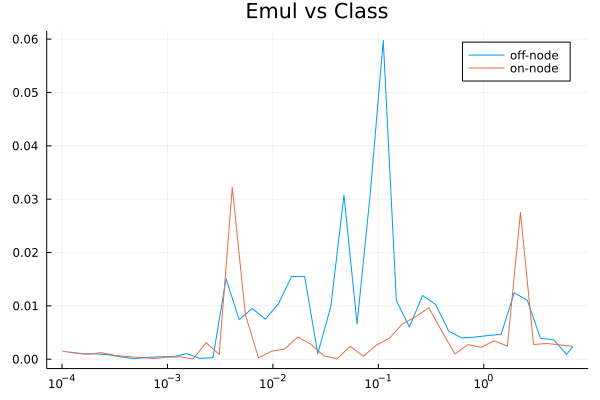

In [92]:
plot(k_arr2, emul_off_node, xaxis=:log,
     label="off-node", title="Emul vs Class")
plot!(k_arr, emul_on_node, xaxis=:log,
      label="on-node")

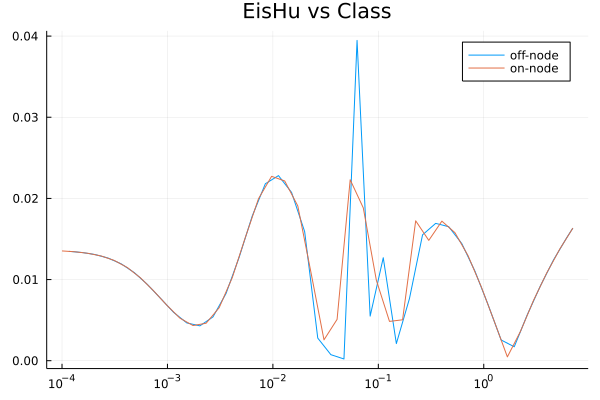

In [93]:
plot(k_arr2, EisHu_off_node, xaxis=:log,
     label="off-node", title="EisHu vs Class")
plot!(k_arr, EisHu_on_node, xaxis=:log,
      label="on-node")

In [75]:
function EisHu(Wm)
    cosmo1 = Cosmology(Wm, 0.039, 0.75, 1.0, 0.72,
                  nk=2000, tk_mode="EisHu")
    return lin_Pk(cosmo1, k_arr, 0.0)
end

EisHu (generic function with 1 method)

In [ ]:
Pk_EisHu

In [23]:
function Emul(Wm)
    cosmo2 = Cosmology(Wm, 0.039, 0.75, 1.0, 0.72,
                      nk=2000, tk_mode="emulator")
    return lin_Pk(cosmo2, k_arr, 0.0)
end

Emul (generic function with 1 method)

In [42]:
function Emul2(Wm)
    params = CosmoPar(Wm, 0.039, 0.75, 1.0, 0.72, 2.725/2.7)
    return get_emulated_log_pk0(params)
end

Emul2 (generic function with 1 method)

In [43]:
@time begin
    for i in 1:100
        EisHu(0.2+0.01*i)
    end
end

  3.327724 seconds (18.28 M allocations: 1.337 GiB, 6.06% gc time)


In [44]:
@time begin
    for i in 1:100
        Emul(0.2+0.01*i)
    end
end

  3.809622 seconds (18.43 M allocations: 1.884 GiB, 5.72% gc time)


In [45]:
@time begin
    for i in 1:100
        Emul2(0.2+0.01*i)
    end
end

  0.442358 seconds (175.00 k allocations: 598.537 MiB, 6.78% gc time)


In [7]:
ref = [1.05199810e+03, 1.39972787e+03, 1.86175310e+03, 2.47485290e+03,
       3.28678329e+03, 4.35879529e+03, 5.76807365e+03, 7.60883617e+03,
       9.99017257e+03, 1.30291073e+04, 1.68341153e+04, 2.14732641e+04,
       2.69244140e+04, 3.30028431e+04, 3.92692797e+04, 4.49267904e+04,
       4.87473257e+04, 4.91726610e+04, 4.49690394e+04, 3.67747863e+04,
       2.82780596e+04, 2.29757121e+04, 1.74933110e+04, 1.07923121e+04,
       7.73217085e+03, 4.73490310e+03, 2.81547163e+03, 1.63726622e+03,
       9.16888584e+02, 5.03788217e+02, 2.70399989e+02, 1.42297928e+02,
       7.35961443e+01, 3.74882941e+01, 1.88420637e+01, 9.35899651e+00,
       4.60024344e+00, 2.24010663e+00, 1.08184944e+00, 5.18425752e-01];

In [8]:
using Plots
plot(k_arr, Pk_EisHu, xaxis=:log, yaxis=:log, label="EisHu")
plot!(k_arr, ref, xaxis=:log, yaxis=:log, label="ref")
plot!(k_arr, Pk_emul_L, xaxis=:log, yaxis=:log, label="Emulator")

LoadError: UndefVarError: Pk_EisHu not defined

In [9]:
plot(k_arr, (Pk_EisHu-Pk_emul_L)./Pk_EisHu, xaxis=:log, label="(EisHu-Emul)/Emul")

LoadError: UndefVarError: Pk_EisHu not defined

In [10]:
plot(k_arr, (ref-Pk_emul_L)./ref, xaxis=:log, label="(ref-Emul)/ref")

LoadError: UndefVarError: Pk_emul_L not defined

In [11]:
plot(k_arr, (ref-Pk_EisHu)./ref, xaxis=:log, label="(ref-EisHu)/ref")

LoadError: UndefVarError: Pk_EisHu not defined